In [62]:
import pandas as pd
from jqdatasdk import *
import talib
Account = 0
Password = 0 
with open('password.txt') as f:
    Account,Password = f.read().splitlines()
auth(Account,Password)
# dfMinute1000 = get_price('IF9999.CCFX', start_date ="2021-06-30 14:00:00",end_date='2022-01-01 14:00:00', frequency='1m')
dfMinute1000 = pd.read_csv('./dfMinute.csv', index_col=0,parse_dates=[0])

In [49]:
def getDataBuffer(data: pd.core.frame.DataFrame, intInPeriod, intOutPeriod, valuePerUnit, initEquity):
    # 计算:多头每日进入 离开 仓位 加仓 止损条件
    datashfit1 = data.shift(1)
    data['inLongSignal'] = datashfit1.rolling(intInPeriod).high.max()  # 进入
    data['outLongSignal'] = datashfit1.rolling(intOutPeriod).low.min()  # 离开
    # 海龟单位在每次现金变动时更新 initEquity*0.01 / (atr * valuePerPoint)
    data['turtleUnit'] = None
    data['atr'] = talib.ATR(datashfit1.high.values, datashfit1.low.values,
                            datashfit1.close.values, timeperiod=intInPeriod)  # 计算atr
    data['addPositon'] = None  # 加仓条件 当前价格大于 建仓价格+0.5atr：每天的加仓条件是（不确定的）
    data['stopLoss'] = None  # 止损条件 当前价格小于 建仓价格-2atr：止损条件取决于当前存在的仓位的开仓价格（不确定的）
    return data

dataBuffer = getDataBuffer(dfMinute1000, 2400, 2400, 1, 1e6)
# 信息查看
print('离开信号量：%s'%dataBuffer[dataBuffer.close<dataBuffer.outLongSignal].shape[0])
print('进入信号量：%s'%dataBuffer[dataBuffer.close>dataBuffer.inLongSignal].shape[0])

离开信号量：198
进入信号量：5


In [51]:
import backtrader as bt
dataBuffer2 = dataBuffer.reset_index()


class myDataPandas(bt.feeds.PandasData):
    lines = ('inLongSignal', 'outLongSignal', 'atr',)
    params = (
        ('datetime', 0),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('inLongSignal', -1),
        ('outLongSignal', -1),
        ('atr', -1))  # learn


class turtle:
    def __init__(self, bid, stop, size):
        self.bid = bid
        self.stop = stop
        self.size = size

    def updateStop(self, atr, orderDirect="BID"):
        """
        开多：coeff = -0.5
        开空：coeff = +0.5
        """
        if orderDirect=="BID":
            self.stop = self.stop  - 0.5*atr
        if  orderDirect=="SELL":
            self.stop = self.stop  + 0.5*atr
    def getStopSize(self, currentPrice,orderDirect):
        """
        返回0 或者 self.size
        """
        if orderDirect=="BID":
            return int(currentPrice < self.stop), (currentPrice < self.stop) * self.size
        if orderDirect=="SELL":
            return int(currentPrice > self.stop), (currentPrice > self.stop) * self.size
        
        

class myStrategy(bt.Strategy):
    def __init__(self):
        self.valuePerUnit = 1
        self.currentTurtleNum = -1  # ordered:因为减仓肯定先减第一只乌龟
        self.currentTurtleBid = []
        self.currentTurtleStopLoss = []
        self.currentTurtleSize = []
        idx = 0
        print('时间', self.datas[0].lines.datetime.time(idx))
        """
            print(self.datas[0].lines.getlinealiases()) #learn
            print('时间',self.datas[0].lines.datetime.time(idx))
            print('开',self.datas[0].lines.open[idx]) #learn
            print('收',self.datas[0].lines.close[idx])
            print('高',self.datas[0].lines.high[idx])
            print('低',self.datas[0].lines.low[idx])
            print('进',self.datas[0].lines.inLongSignal[idx])
            print('出',self.datas[0].lines.outLongSignal[idx])
            print('当前持仓量', self.getposition(self.data).size)
            print('当前持仓成本', self.getposition(self.data).price)
            print('数据集名称列表',self.getdatanames())
        """
        pass

    def myBuy(self):
        currentValue = self.broker.getvalue()
        turtleUnit = currentValue*0.001 / \
            (self.datas[0].lines.atr[0]*self.valuePerUnit)  # 报价单位
        cashMayNeed = turtleUnit * \
            (self.datas[0].lines.close[0] + 1)*self.valuePerUnit
        positionCash = self.broker.getcash()
        # print(f'atr {self.datas[0].lines.atr[0]}; close {self.datas[0].lines.close[0]}')
        # print("currentvalue %d,positionCash is %d,cashMayNeed is %d"%(currentValue, positionCash, cashMayNeed))
        # 出现一种现象：因为波动太小，要买的数量超过本金，我们就最大风险设为千分之1
        if positionCash > cashMayNeed:
            # 买
            self.order = self.buy(data=self.datas[0], size=turtleUnit)
            # 龟之买价

            # 龟之止损价格
            if self.currentTurtleStopLoss:
                # 如果是开仓直接添加 如果加仓需要先将已有的龟-0.5N
                self.currentTurtleStopLoss.append(self.datas[0].lines.close[0] - 2*self.datas[0].lines.atr[0])  # 不符合实际
                self.currentTurtleBid.append(self.datas[0].lines.close[0])  # 不符合实际
                self.currentTurtleSize.append(turtleUnit)
            else:
                self.currentTurtleStopLoss = [i - 0.5*self.datas[0].lines.atr[0] for i in self.currentTurtleStopLoss]
                self.currentTurtleStopLoss.append(self.datas[0].lines.close[0] - 2*self.datas[0].lines.atr[0])
                self.currentTurtleBid.append(self.datas[0].lines.close[0])  # 不符合实际
                self.currentTurtleSize.append(turtleUnit)
            # 龟之数量
            self.currentTurtleNum += 1

        return 0

    def mySell(self, numTurtle, sizeTurtle):
        self.order = self.sell(data=self.datas[0], size=sizeTurtle)
        del self.currentTurtleBid[:numTurtle]
        del self.currentTurtleStopLoss[:numTurtle]
        del self.currentTurtleSize[:numTurtle]
        self.currentTurtleNum -= numTurtle

    def myPositonLog(self):
        print('turtleNum,turtleSize,turtleBid,turtleStopLoss')
        print(self.currentTurtleNum,
              self.currentTurtleSize,
              self.currentTurtleBid,
              self.currentTurtleStopLoss)
        print('\n \n')

    def next(self):
        # 开仓逻辑
        currentClose = self.datas[0].lines.close[0]
        # print('current price %\t current turtle %d', currentClose, self.currentTurtleNum)
        if self.currentTurtleNum == -1:
            # 开仓限制1
            if currentClose > self.datas[0].lines.inLongSignal[0]:
                # 开仓条件
                # 计算仓位
                self.myBuy()
                print(self.datas[0].lines.datetime.date(0), self.datas[0].lines.datetime.time(0), 'buy')
                self.myPositonLog()
        # 加仓逻辑
        if -1 < self.currentTurtleNum < 3:
            # 当前价格比最新海龟建仓价格高0.5N
            if currentClose > self.currentTurtleBid[self.currentTurtleNum]+0.5*self.datas[0].lines.atr[0]:
                self.myBuy()
                print(self.datas[0].lines.datetime.date(0), self.datas[0].lines.datetime.time(0), 'add')
                self.myPositonLog()
        # 止损逻辑
        if self.currentTurtleNum != -1:
            needStopSize, needStopTurtle = 0, 0
            for turtle in range(self.currentTurtleNum+1):
                if currentClose < self.currentTurtleStopLoss[turtle]:
                    needStopSize += self.currentTurtleSize[turtle]
                    needStopTurtle += 1
            if needStopTurtle:
                self.mySell(needStopTurtle, needStopSize)
                print(self.datas[0].lines.datetime.date(0),
                      self.datas[0].lines.datetime.time(0), 'sell %d' % needStopTurtle)
                self.myPositonLog()
        # 离开逻辑
        if currentClose < self.datas[0].lines.outLongSignal[0] and self.currentTurtleNum > -1:
            self.close()
            print(self.datas[0].lines.datetime.date(0), self.datas[0].lines.datetime.time(0), 'close')
            self.myPositonLog()
            self.currentTurtleBid.clear()
            self.currentTurtleStopLoss.clear()
            self.currentTurtleSize.clear()
            self.currentTurtleNum = -1


class myStrategy2(bt.Strategy):
    def __init__(self):
        self.valuePerUnit = 10
        self.turtles = []
        self.currentTurtleNum = -1  # ordered:因为减仓肯定先减第一只乌龟
        #self.currentTurtleBid = []
        #self.currentTurtleStopLoss = []
        #self.currentTurtleSize = []
        idx = 0
        print('时间', self.datas[0].lines.datetime.time(idx))
        """
            print(self.datas[0].lines.getlinealiases()) #learn
            print('时间',self.datas[0].lines.datetime.time(idx))
            print('开',self.datas[0].lines.open[idx]) #learn
            print('收',self.datas[0].lines.close[idx])
            print('高',self.datas[0].lines.high[idx])
            print('低',self.datas[0].lines.low[idx])
            print('进',self.datas[0].lines.inLongSignal[idx])
            print('出',self.datas[0].lines.outLongSignal[idx])
            print('当前持仓量', self.getposition(self.data).size)
            print('当前持仓成本', self.getposition(self.data).price)
            print('数据集名称列表',self.getdatanames())
        """

    def myBuy(self):
        currentValue = self.broker.getvalue()
        turtleUnit = currentValue*0.005 / \
            (self.datas[0].lines.atr[0]*self.valuePerUnit)  # 报价单位
        cashMayNeed = turtleUnit * \
            (self.datas[0].lines.close[0] + 1)*self.valuePerUnit * 0.1  # 期货这里用保证金交易
        positionCash = self.broker.getcash()
        # print(f'atr {self.datas[0].lines.atr[0]}; close {self.datas[0].lines.close[0]}')
        # print("currentvalue %d,positionCash is %d,cashMayNeed is %d"%(currentValue, positionCash, cashMayNeed))
        # 出现一种现象：因为波动太小，要买的数量超过本金，我们就最大风险设为千分之1
        if positionCash > cashMayNeed:
            print('Cash is enough!->cashMayNeed:%.2f,positionCash:%.2f' % (cashMayNeed, positionCash))
            # 买
            self.order = self.buy(data=self.datas[0], size=turtleUnit)

            # 龟之买价
            self.turtles.append(turtle(self.datas[0].lines.close[0],
                                       self.datas[0].lines.close[0] - 2*self.datas[0].lines.atr[0],
                                       turtleUnit))
            if len(self.turtles) > 1:
                # 开仓的时候不需要更新，但是因为用的都是一个函数所以加上if
                [turtle.updateStop(self.datas[0].lines.atr[0]) for turtle in self.turtles[:-1]]
            self.currentTurtleNum += 1
        else:
            print('Cash is lacked!')
        return 0

    def mySell(self, numTurtle, sizeTurtle):

        self.order = self.sell(data=self.datas[0], size=sizeTurtle)
        del self.turtles[:numTurtle]
        self.currentTurtleNum -= numTurtle
        return 0

    def myPositonLog(self, operation: str):
        print(self.datas[0].lines.datetime.date(0), self.datas[0].lines.datetime.time(0), operation)
        print(f'{operation}Pirce:    {self.datas[0].lines.close[0]:.2f}')
        print('turtleNum:   %d' % self.currentTurtleNum)
        print('%-20s%-20s%-20s' % ('turtleSize', 'turtleBid', 'turtleStopLoss'))
        for turtle in self.turtles:
            print('%-20.2f%-20.2f%-20.2f' % (turtle.size, turtle.bid, turtle.stop))
        print('\n')
        return 0

    def next(self):
        # 开多逻辑
        currentClose = self.datas[0].lines.close[0]
        if self.currentTurtleNum == -1:
            # 开仓限制1
            if currentClose > self.datas[0].lines.inLongSignal[0]:
                # if currentClose < self.datas[0].lines.outLongSignal[0]:
                # 开仓条件
                # 计算仓位
                self.myBuy()
                self.myPositonLog('buy')
        # 加仓逻辑
        if -1 < self.currentTurtleNum < 3:
            # 当前价格比最新海龟建仓价格高0.5N
            if currentClose > self.turtles[-1].bid + 0.5*self.datas[0].lines.atr[0]:
                self.myBuy()
                self.myPositonLog('add')
        # 止损逻辑
        if self.currentTurtleNum != -1:
            needStopSize, needStopTurtle = 0, 0
            for turtle in self.turtles:
                if currentClose < turtle.stop:
                    needStopSize += turtle.size
                    needStopTurtle += 1
            if needStopTurtle:
                self.mySell(needStopTurtle, needStopSize)
                self.myPositonLog(f'sell {needStopTurtle}')

        # 离开逻辑
        if currentClose < self.datas[0].lines.outLongSignal[0] and self.currentTurtleNum > -1:
            # if currentClose > self.datas[0].lines.inLongSignal[0] and self.currentTurtleNum > -1:
            self.close()

            self.myPositonLog('close')
            self.turtles.clear()
            self.currentTurtleNum = -1


class myStrategy3(bt.Strategy):
    """
    多空
    """

    def __init__(self):
        self.direct = 'BID' # or SELL 
        self.valuePerUnit = 300
        self.turtles = []
        self.currentTurtleNum = -1  # ordered:因为减仓肯定先减第一只乌龟
        #self.currentTurtleBid = []
        #self.currentTurtleStopLoss = []
        #self.currentTurtleSize = []
        idx = 0
        print('时间', self.datas[0].lines.datetime.time(idx))
        """
            print(self.datas[0].lines.getlinealiases()) #learn
            print('时间',self.datas[0].lines.datetime.time(idx))
            print('开',self.datas[0].lines.open[idx]) #learn
            print('收',self.datas[0].lines.close[idx])
            print('高',self.datas[0].lines.high[idx])
            print('低',self.datas[0].lines.low[idx])
            print('进',self.datas[0].lines.inLongSignal[idx])
            print('出',self.datas[0].lines.outLongSignal[idx])
            print('当前持仓量', self.getposition(self.data).size)
            print('当前持仓成本', self.getposition(self.data).price)
            print('数据集名称列表',self.getdatanames())
        """
    
    def myCalUnit(self, riskPercent=0.005):
        "返回一个double和一个bool:不用返回bool，如果现金不够，backtrader会自动处理的"
        equityValue = self.broker.getvalue()
        turtleUnit = equityValue*riskPercent / \
            (self.datas[0].lines.atr[0]*self.valuePerUnit)  # 报价单位
        return turtleUnit

    def myOpen(self, orderDirect):

        turtleUnit = self.myCalUnit(0.005)
        if orderDirect=="BID":
            self.order = self.buy(data=self.datas[0], size=turtleUnit)
            self.turtles.append(turtle(self.datas[0].lines.close[0],
                                       self.datas[0].lines.close[0] - 2*self.datas[0].lines.atr[0],
                                       turtleUnit))#  不准确
            self.direct = orderDirect
        if orderDirect=="SELL":
            self.order = self.sell(data=self.datas[0], size=turtleUnit)
            self.turtles.append(turtle(self.datas[0].lines.close[0],
                                       self.datas[0].lines.close[0] + 2*self.datas[0].lines.atr[0],
                                       turtleUnit))#  不准确
            self.direct = orderDirect

    def myAdd(self, orderDirect):
        atr = self.datas[0].lines.atr[0]
        self.myOpen(orderDirect=orderDirect)
        [turtle.updateStop(atr, orderDirect=orderDirect) for turtle in self.turtles[:-1]]

    def myStop(self, orderDirect, currentPrice):

        stopSize, stopNum = 0,0
        for turtle in self.turtles:
            boolStop, stopSize1 = turtle.getStopSize(currentPrice, orderDirect)
            stopNum+=boolStop
            stopSize+=stopSize1
        if orderDirect=="BID":
            "1.cal stop size"
            "2.order"
            self.order = self.sell(data=self.datas[0], size=stopSize)
        if orderDirect=="SELL":
            self.order = self.buy(data=self.datas[0], size=stopSize)
        del self.turtles[:stopNum]

    def myClose(self,orderDirect):
        self.close()
        self.turtles.clear()
        
    def myPositonLog(self, operation: str):
        print(self.datas[0].lines.datetime.date(0), self.datas[0].lines.datetime.time(0), operation)
        print(f'{operation}Pirce:    {self.datas[0].lines.close[0]:.2f}')
        print('turtleNum:   %d' % len(self.turtles))
        print('%-20s%-20s%-20s' % ('turtleSize', 'turtleBid', 'turtleStopLoss'))
        for turtle in self.turtles:
            print('%-20.2f%-20.2f%-20.2f' % (turtle.size, turtle.bid, turtle.stop))
        print('\n')
        return 0

    def next(self):
        # 开多逻辑：如果满足条件，且当前方向是BID or 当前方向是SELL，但满足开多条件
        currentClose = currentClose = self.datas[0].lines.close[0]
        if (self.direct == "BID" and len(self.turtles)==0 and currentClose > self.datas[0].lines.inLongSignal[0]) | (self.direct == "SELL" and currentClose > self.datas[0].lines.inLongSignal[0]):
            if self.direct == "SELL":
                self.myClose(orderDirect="SELL")
            self.myOpen(orderDirect='BID')
        # 开空逻辑
        if (self.direct == "SELL" and len(self.turtles)==0 and currentClose < self.datas[0].lines.outLongSignal[0]) | (self.direct == "BID" and currentClose < self.datas[0].lines.outLongSignal[0]):
            if self.direct == "BID":
                self.myClose(orderDirect="BID")
            self.myOpen(orderDirect='SELL')
        # 加仓逻辑
        if 4>len(self.turtles)>0:
            if self.direct=="BID" and currentClose > self.turtles[-1].bid + 0.5*self.datas[0].lines.atr[0]:
                self.myAdd(orderDirect="BID")
            if self.direct=="SELL" and currentClose < self.turtles[-1].bid - 0.5*self.datas[0].lines.atr[0]:
                self.myAdd(orderDirect="SELL")
        # 止损逻辑(合并止损)
        if len(self.turtles)>0:
            if self.direct=="BID":
                self.myStop(orderDirect="BID", currentPrice = currentClose)
            if self.direct=="sell":
                self.myStop(orderDirect="SELL",currentPrice = currentClose)
        


        

class ComminfoFuturesPercent(bt.CommInfoBase):
    '''write by myself,using in the future backtest,it means we should give a percent comminfo to broker'''
    params = (
        ('stocklike', False),
        ('commtype', bt.CommInfoBase.COMM_PERC),
        ('percabs', True)
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * price * self.p.mult * self.p.commission

    def get_margin(self, price):
        return price * self.p.mult * self.p.margin


comm_rb = ComminfoFuturesPercent(commission=1e-4, margin=0.09, mult=300.0)
# cerebro = bt.Cerebro()
# cerebro.broker.addcommissioninfo(comm_rb, name='RB')


In [52]:
import datetime
## 1.数据
# dataBackTrader = myDataPandas(dataname=dataBuffer2,fromdate=datetime.datetime(2021,6,30,9,0,0),todate=datetime.datetime(2021,12,31,15,0,0))#learn
dataBackTrader = myDataPandas(dataname=dataBuffer2,fromdate=datetime.datetime(2022,1,1,9,0,0),todate=datetime.datetime(2022,4,30,15,0,0))#learn
cerebro = bt.Cerebro()
cerebro.adddata(dataBackTrader,name='RB') #RB代表螺纹钢
## 2.交易
cerebro.broker.set_cash(1e6)
cerebro.broker.set_slippage_perc(perc=0.0001, slip_out=False)
# cerebro.broker.setcommission(commission=0.0001)
cerebro.broker.addcommissioninfo(comm_rb, name='RB')
cerebro.addstrategy(myStrategy3)
cerebro.run()

时间 15:00:00


<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>]]

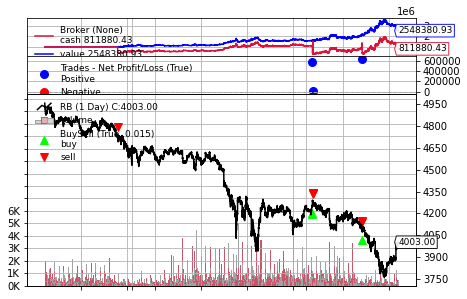

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
cerebro.plot()
#plt.plot([1,2])

In [24]:
dfMinute1000

,open,close,high,low,volume,money,inLongSignal,outLongSignal,turtleUnit,atr,addPositon,stopLoss
2021-06-30 14:00:00,5185.0,5183.8,5185.8,5183.8,239.0,3.717597e+08,NaN,NaN,None,NaN,None,None
2021-06-30 14:01:00,5183.6,5180.0,5183.6,5180.0,694.0,1.078821e+09,NaN,NaN,None,NaN,None,None
2021-06-30 14:02:00,5181.4,5183.2,5183.4,5180.0,353.0,5.487611e+08,NaN,NaN,None,NaN,None,None
2021-06-30 14:03:00,5183.2,5184.6,5186.0,5183.2,216.0,3.359655e+08,NaN,NaN,None,NaN,None,None
2021-06-30 14:04:00,5184.8,5185.6,5186.2,5184.0,113.0,1.757824e+08,NaN,NaN,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 14:56:00,4946.6,4946.6,4947.8,4945.8,383.0,5.684277e+08,5161.6,4892.6,None,3.305452,None,None
2021-12-31 14:57:00,4947.0,4946.2,4947.2,4946.0,252.0,3.739624e+08,5161.6,4892.6,None,3.305180,None,None
2021-12-31 14:58:00,4946.4,4945.0,4946.8,4945.0,421.0,6.246613e+08,5161.6,4892.6,None,3.304741,None,None
2021-12-31 14:59:00,4945.0,4943.2,4945.6,4943.2,509.0,7.550327e+08,5161.6,4892.6,None,3.304428,None,None
